In [1]:
import os
import matplotlib.pyplot as plt

import numpy as np
from src.reslith_util import combine_cptttem, plot_reslith, \
    build_reslithtransform, apply_reslithtransform

cptpath = os.path.join('input_files', 'Example_CPT')

# Read in tTEM data
respath = os.path.join('input_files', 'Example_tTEM')
ttem = np.loadtxt(respath, skiprows=6)
ttem[ttem == -999] = np.nan

# Remove NaN values
ttem = ttem[~np.isnan(ttem).any(axis=1)]

# Read in cpt data (only load in x, y, z, and coarsefrac cols)
cpt = np.loadtxt(cptpath, skiprows=7, usecols=[0, 1, 2, 4])

# Create array of collocated CPT and tTEM profiles
# This averages the CPT data to the tTEM resolution
# The array has shape (n, 5) with columns x, y, z, resistivity, coarse fraction
cptttem = combine_cptttem(cpt, ttem)
cptttem = cptttem[~np.isnan(cptttem).any(axis=1)]

### Build resistivity-lithology transform for the vadose zone

##### Step 1:
First, we use collocated CPT and tTEM profiles to calculate the distribution of tTEM resistivity values for coarse- and fine-grained end members. This generates what we refer to as `vad_end_relat`.

##### Step 2:
Next, to calculate the resistivity-lithology relationship for coarse fraction values between 0 and 1, we sample from each distribution and calculate tTEM resistivity ($\rho_{\text{tTEM}}$) as:
$\rho_{\text{tTEM}} = \bigg( C_F \frac{1}{\rho_{\text{coarse}}} + (1 - C_F) \frac{1}{\rho_{\text{fine}}} \bigg)^{-1}$

where $C_F$ is the coarse fraction of a cell, $\rho_{\text{coarse}}$ is the bootstrapped resistivity value of the coarse-grained end member and $\rho_{\text{fine}}$ is the bootstrapped resistivity value of the fine-grained end member. This process generates `vad_all_relat`.

##### Step 3:
Finally, we generate a resistivity-lithology transform (`vad_trans`). This is effectively a lookup table containing the cumulative distribution function of likely coarse fraction values for each potential resistivity value. In this array, the columns correspond to binned resistivity values and the rows correspond to quantiles between 0 and 1. Thus, the cell (quantile_i, resbin_j) contains the coarse fraction value at quantile_i for resistivity bin resbin_j. For example, to apply this transform using the "most likely" (50th percentile) coarse fraction value, use `vad_trans[500, :]` (I'm assuming that n_quantiles = 1000).


Building resistivity-lithology transform:   0%|          | 0/493 [00:00<?, ?it/s]

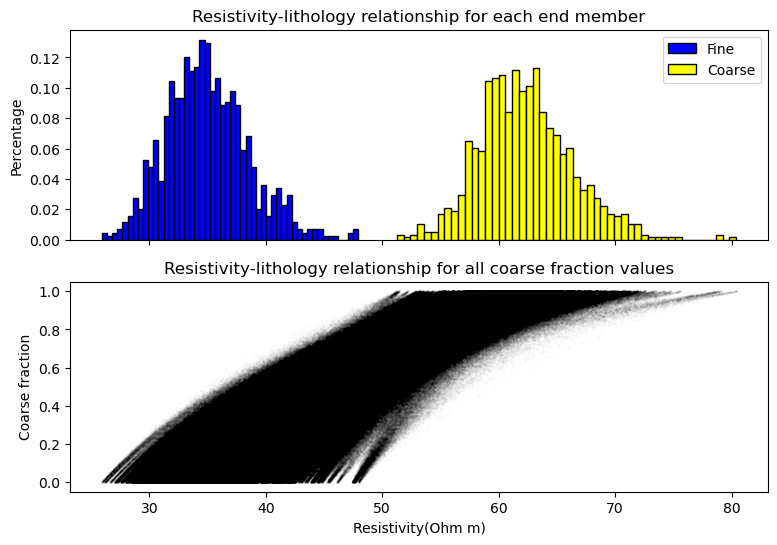

In [2]:
from scipy.optimize import nnls

# Number of bootstrapped samples to take from the collocated
# resistivity and lithology array
nboots = 1000

# Create cptlith, which contains [fine fraction, coarse fraction]
cptlith = np.hstack((1-cptttem[:, -1:], cptttem[:, -1:]))
ttem_res = cptttem[:, -2]

# Instantiate array for resistivity-lithology relationship in the vadose zone
vad_end_relat = np.zeros((nboots, 2), dtype=float)

ns = cptlith.shape[0]

### Step 1: Calculate vadose zone resistivity-lithology relationship
# for coarse and fine-grained end members
for nb in range(nboots):
    idx = np.random.choice(range(ns), ns)
    XB = cptlith[idx, :]
    y_ttem = 1/ttem_res[idx]
    vad_end_relat[nb, :] = 1/nnls(XB, y_ttem)[0]

### Step 2: Calculate resistivity-lithology relationship for coarse
# fraction values between 0 and 1
cf = np.arange(0, 1+1e-9, 0.001)  # Coarse frac values at which to evaluate
nf = cf.shape[0]
niter = 10000  # Number of times to evaluate rho_tTEM

rho_fine_boot = np.random.choice(vad_end_relat[:, 0], (niter, nf))
rho_coarse_boot = np.random.choice(vad_end_relat[:, 1], (niter, nf))
coarsemat = np.tile(cf, (niter, 1))
finemat = 1 - coarsemat

# Calculate resistivity using equation above
vad_all_relat = 1/((1/rho_fine_boot)*finemat + (1/rho_coarse_boot)*coarsemat)

### Step 3: Finally, build resistivity-lithology transform
vad_trans, vad_resvals = build_reslithtransform(vad_all_relat, cf)

# Plot both reslith and rpm
fig, ax = plot_reslith(vad_end_relat, vad_all_relat, cf, bins=50)
ax[0].set(title='Resistivity-lithology relationship for each end member')
_ = ax[1].set(title='Resistivity-lithology relationship for all coarse fraction values')

### Save the resistivity-lithology transform to file

In [3]:
# First row is the log10(resistivity) bins used for the transform,
# everything else is the rpt

if np.count_nonzero(np.isnan(vad_trans)) > 0:
    print('WARNING -- Vadose zone RPT has NaN values')

np.save('output_files/VadoseZoneResistivityLithologyTransform.npy',
        np.vstack((vad_resvals, vad_trans)))

### Apply resistivity-lithology transform to a realization of resistivity

In this step, we apply the resistivity-lithology transform to a realization of resistivity. For this example, we're assuming all data are from the vadose zone, so there is no need to apply multiple transforms (vadose zone, saturated zone, transition zone, etc). In addition, we're evaluating the transform at the 50th percentile for all resistivity bins, though `apply_reslithtransform` can implement more complex transforms using the `min_quantile=` and `max_quantile=` keywords.


In [4]:
realfile = os.path.join('input_files', 'Example_ResRealization.npy')
res_real = np.log10(np.load(realfile))

# Apply rpt to vadose zone
print('Transforming vadose zone...')
cf_real = apply_reslithtransform(res_real, vad_trans, vad_resvals)

savepath = os.path.join('output_files', 'Example_CFRealization.npy')
np.save(savepath, cf_real)
print('Done.')


Transforming vadose zone...
Done.


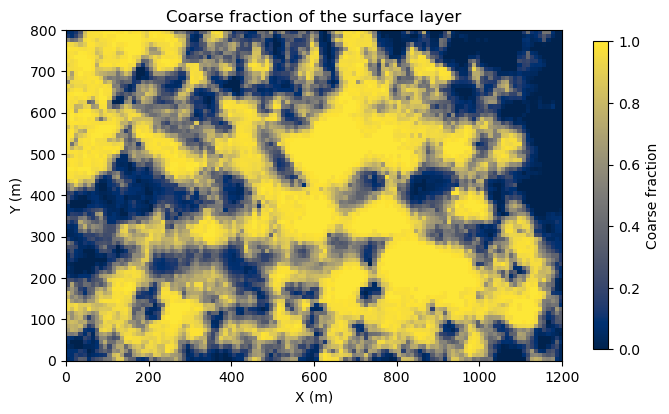

In [5]:
# Plot the surface layer of the resulting coarse fraction realization
fig, ax = plt.subplots(figsize=(8, 8))

im = ax.imshow(cf_real[:, :, -1].T, cmap='cividis', vmin=0, vmax=1,
               extent=[0,1200,0,800])
fig.colorbar(im, ax=[ax], shrink=0.5, label='Coarse fraction')

_ = ax.set(xlabel='X (m)', ylabel='Y (m)', title='Coarse fraction of the surface layer')